<a href="https://colab.research.google.com/github/carlosfab/escola-data-science/blob/master/notebooks/Aula_007_Gradient_Descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gradient Descent

Recapitulando tudo que foi visto até o momento, vimos que a previsão $\hat{y} = \sigma(w^Tx + b)$, onde $\sigma(z) = \frac{1}{1 + e^{-z}}$, pode ter seu desempenho avaliado por meio de uma função custo.

A função custo representa a avaliação conjunta das amostras. Em outras palavras, mede quão bom é o desempenho dos nossos parâmetros $w$ e $b$. No caso da regressão logística, estamos usando a seguinte função custo:

$$
J(w, b) = \frac{1}{m} \sum_{i=1}^{m}\mathcal{L}(\hat{y}^{(i)}, y^{(i)}) = - \frac{1}{m} \sum_{i=1}^{m} [y^{(i)} \log \hat{y}^{(i)} + (1 - y^{(i)})log(1 - \hat{y}^{(i)})]
$$

Quanto menor foi o valor da função custo, melhor. A ação de "otimizar" é feita pelo algoritmo *Gradient Descent*. Veja sua representação espacial considerando nossos dois parâmetros.

<p align="center"><img src="https://raw.githubusercontent.com/carlosfab/escola-data-science/master/img/gradient_descent.gif" height="300px"></p>

### *Forward* e *Backward Propagation*

Recomendo assistir à aual e prestar atenção aos slides. Todo o conteúdo teórico foi passado por lá.

Vamos recuperar as etapadas passadas na última aula, que incluiam apenas o passe de ida, e acrescentar o caminho de volta. Nesta etapa, *backward propagation*, é onde conseguimos melhorar cada parâmetro, obtendo as derivadas de cada um.

**Etapas da *forward + backward propagation***
1. Padronizar as dimensões de `X` e `y`
2. Inicializar os parâmetros `w` e `b`
3. Calcular $z = w^T x + b$
4. Calcular $\sigma(-z) = \frac{1}{1 + e^{(-z)}}$
5. Calcular $J(w, b) = - \frac{1}{m} \sum_{i=1}^{m} [y^{(i)} \log \hat{y}^{(i)} + (1 - y^{(i)})log(1 - \hat{y}^{(i)})]$
6. Calcular os gradientes de cada parâmetro usando:
  * $\frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T$
  * $\frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})$

In [1]:
# importa bibliotecas
import h5py
import numpy as np
import matplotlib.pyplot as plt

# download do dataset cat vs non-cat
!wget -q https://raw.githubusercontent.com/carlosfab/escola-data-science/master/datasets/catvsnoncat/train_catvnoncat.h5
!wget -q https://raw.githubusercontent.com/carlosfab/escola-data-science/master/datasets/catvsnoncat/test_catvnoncat.h5

# Importar os dados do arquivo .h5
train_dataset = h5py.File('train_catvnoncat.h5', 'r')
test_dataset = h5py.File('test_catvnoncat.h5', 'r')

# dados de treino
train_x = np.array(train_dataset['train_set_x'][:])
train_y = np.array(train_dataset['train_set_y'][:])

# dados de teste
test_x = np.array(test_dataset['test_set_x'][:])
test_y = np.array(test_dataset['test_set_y'][:])

# reshape nas variáveis
train_y = train_y.reshape(1, train_y.shape[0])
test_y = test_y.reshape(1, test_y.shape[0])
train_x_flatten = train_x.reshape(train_x.shape[0], -1).T
test_x_flatten = test_x.reshape(test_x.shape[0], -1).T

Checar a dimensionalidade dos objetos.

In [2]:
# ver a dimensionalidade dos nossos dados de treino e teste
for _, j in enumerate([train_x_flatten, train_y, test_x_flatten, test_y]):
    print(j.shape)

(12288, 209)
(1, 209)
(12288, 50)
(1, 50)


Dividir por 255 para padronizar os datasets.

In [3]:
# padronizar os inputs
train_x_clean = train_x_flatten / 255.
test_x_clean = test_x_flatten / 255.

**Etapas da *forward + backward propagation***
1. Padronizar as dimensões de `X` e `y`
2. Inicializar os parâmetros `w` e `b`
3. Calcular $z = w^T x + b$
4. Calcular $\sigma(-z) = \frac{1}{1 + e^{(-z)}}$
5. Calcular $J(w, b) = - \frac{1}{m} \sum_{i=1}^{m} [y^{(i)} \log \hat{y}^{(i)} + (1 - y^{(i)})log(1 - \hat{y}^{(i)})]$
6. Calcular os gradientes de cada parâmetro usando:
  * $\frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T$
  * $\frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})$

In [4]:
def propagate(X, Y):
    # ver qde de amostras
    m = X.shape[1]

    # inicializar variáveis em 0
    w = np.zeros((X.shape[0], 1))
    b = 0

    # calcular z = wx + b
    z = np.dot(w.T, X) + b

    # aplicar a função sigmóide
    A = 1 / (1 + np.exp(-z))

    # calcular custo
    cost = (-1 / m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A)))

    # calcular os gradientes na backward propagation
    dw = (1/m) * np.dot(X, (A - Y).T)
    db = (1/m) * np.sum(A - Y)

    return cost, dw, db

O algoritmo *Gradient Descent* usará os gradientes para encontrar a direção e o parâmetro $\alpha$ para o tamanho do *step*.

Iterando até o critério de parada definido, atualiza os valores de $w$ e $b$ da seguinte maneira:

$$
w := w - \alpha \frac{\partial J(w, b)}{\partial w} \\
b := b - \alpha \frac{\partial J(w, b)}{\partial b}
$$

Lembre-se que as derivadas parciais de cada parâmetro são encontradas usando:

$$
\begin{align}
\frac{\partial J}{\partial w} &= \frac{1}{m}X(A-Y)^T \\
\frac{\partial J}{\partial b} &= \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})
\end{align}
$$

In [5]:
def optimize(X, Y, num_iter=100, alpha=0.01):
    # ver qde de amostras
    m = X.shape[1]

    # inicializar parâmetros em 0
    w = np.zeros((X.shape[0], 1))
    b = 0

    # registrar custo
    costs = []

    for i in range(num_iter):
        # calcular z = wx + b
        z = np.dot(w.T, X) + b

        # aplicar a função sigmóide
        A = 1 / (1 + np.exp(-z))

        # calcular custo
        cost = (-1 / m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A)))
        costs.append(cost)

        # calcular os gradientes na backward propagation
        dw = (1/m) * np.dot(X, (A - Y).T)
        db = (1/m) * np.sum(A - Y)

        # atualizar os parâmetros
        w = w - alpha * dw
        b = b - alpha * db

    return costs, w, b

Abaixo, um pequeno teste para ver se não erramos as dimensões de nenhuma matriz.

In [6]:
# testar a função acima
X, Y = np.array([[2.,1.,-2.],[2.,1.,-3.2]]), np.array([[1,0,1]])

costs, w, b = optimize(X, Y, 100, 0.01)

print ("w = ", w)
print ("b = ", b)

w =  [[-0.04031079]
 [-0.19041433]]
b =  0.14974150109434572


Veja como o custo $J(w, b) = - \frac{1}{m} \sum_{i=1}^{m} [y^{(i)} \log \hat{y}^{(i)} + (1 - y^{(i)})log(1 - \hat{y}^{(i)})]$ diminui ao longo das iterações.

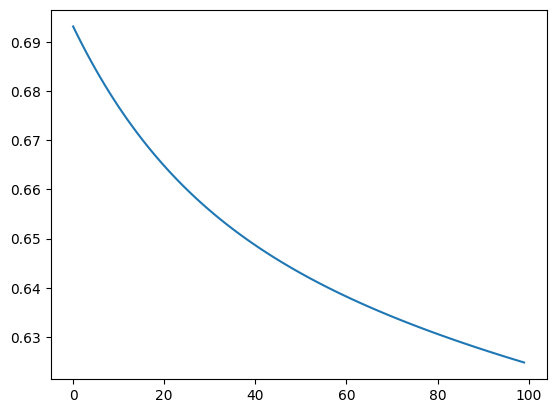

In [7]:
# ver a função custo
plt.plot(costs)
plt.show()

Uma outra etapa agora é realizar previsões. Uma vez que já esteja treinado, extraimos os valores encontrados de $w$ e $b$ e passamos a imagem desejada pelo *forward propagation*.

In [8]:
# fazer previsão

def predict(w, b, X):
    # ver qde de amostras
    m = X.shape[1]

    # criar array para previsões
    w = w.reshape((X.shape[0], 1))
    # y_hat = np.zeros((1, m))

    # calcular probabilidade de ser da classe
    # calcular z = wx + b
    z = np.dot(w.T, X) + b

    # aplicar a função sigmóide
    A = 1 / (1 + np.exp(-z))

    # converter as probabilidades em previsões
    y_hat = np.where(A > 0.5, 1., 0.).reshape((1, m))

    return y_hat

Mais um teste a fim de evitar erros de dimensionalidade.

In [9]:
# fazer um teste para ver se o modelo está ok
w = np.array([[0.74732],[0.41354]])
b = -0.1
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = ", (predict(w, b, X)))

predictions =  [[1. 0. 0.]]


Por fim, vamos usar nosso conjunto de dados *cat vs. non-cat* e ver como a rede neural se comporta frente a dados reais.

In [10]:
# treinar o modelo no dataset de treino
costs, w, b = optimize(train_x_clean, train_y, 2000, 0.001)

# fazer previsões no dataset de teste
predictions = predict(w, b, test_x_clean)

# ver acurácia do modelo
print("Acurácia do dataset de teste: {}".format(100 - np.mean(np.abs(predictions - test_y)) * 100))

Acurácia do dataset de teste: 68.0


Plotaremos o gráfico do custo vs. número de iterações para ver o desempenho do *Gradient Descent*.

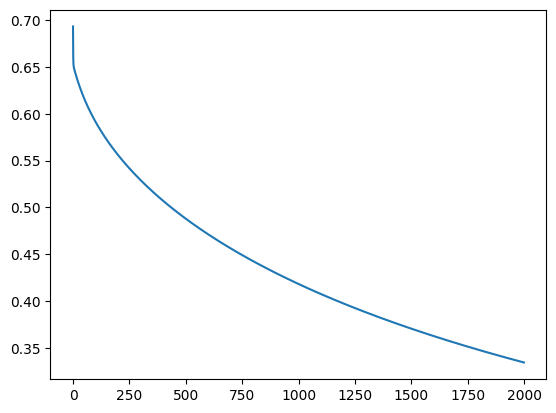

In [11]:
plt.plot(costs)
plt.show()